<a href="https://colab.research.google.com/github/paulmyr/DD2365-AdvancedCFD/blob/master/report-Navier-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [25]:
# This program is an example file for the course
# DD2365 Advanced Computation in Fluid Mechanics,
# KTH Royal Institute of Technology, Stockholm, Sweden.

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

# **Set up environment**

In [26]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity, and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

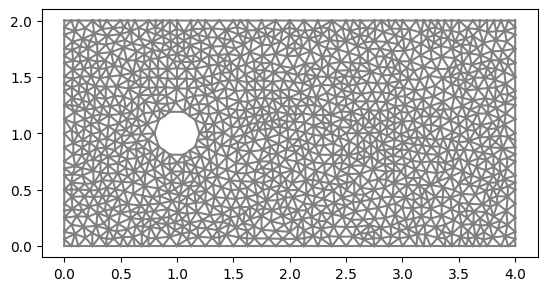

In [27]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [28]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [29]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0

bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

The Reynolds number is given as $RE = \frac{UL}{\nu}$.
The characteristic length L is given by the cylinders diameter $L = 1$, and the characteristic velocity is $U = 0.4$ (set $u_{in} = 0.4$)

For $\nu \in \{4.0\cdot 10^{-1}, ..., 4.0 \cdot 10^{-4}\}$  we get $RE \in \{1, ..., 1000\}$

**Define flow parameters**

In [30]:
# Set viscosity
nu = 4.0e-3
RE = (2 * rc * uin) / nu

print(f"RE = (U * L) / nu = ({uin} * {2 * rc}) / {nu} = {RE}")

RE = (U * L) / nu = (1.0 * 0.4) / 0.004 = 100.0


**Define method parameters**

In [31]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [32]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Triple decomposition**

In [33]:
import scipy.linalg.lapack as la
import numpy as np

def triple_decomposition(grad_u):
    new_grad = np.array([[0,0,0],
                         [0,0,0],
                         [0,0,0]])
    for i in range(2):
      for j in range(2):
        new_grad[i,j] = grad_u[i,j]
    def dselect(arg1,arg2): return (arg2==0)
    T = la.dgees(dselect,new_grad,sort_t = 1)[0]
    sh = np.linalg.norm([T[0,1],T[0,2],T[1,2]+T[2,1]])
    el = np.linalg.norm(np.diag(T))
    rr = np.sqrt(2*min(abs(T[1,2]),abs(T[2,1]))**2)
    return sh, el, rr

**Compute force on boundary**

In [34]:
# Define the direction of the force to be computed
phi_x = 1.0
phi_y = 0.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization (not sure why -2.0 though...?)
# U = 1, rho = 1, D = 2 * rc
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [35]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2ceb50cb6788f17a57a5243de6028cf74d3af8fb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_194419, f_194422]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0365012 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d9c4bb526dbac6c9ee9537c7f34d81b41517c859

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_194419, f_194422, f_194428]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0375156 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_029cccf75b71d9fc779343c9a75b87a3a7194a21

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_194419, f_194422, f_194428, f_194432]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0260973 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC

Time t = 0.03285506167650246


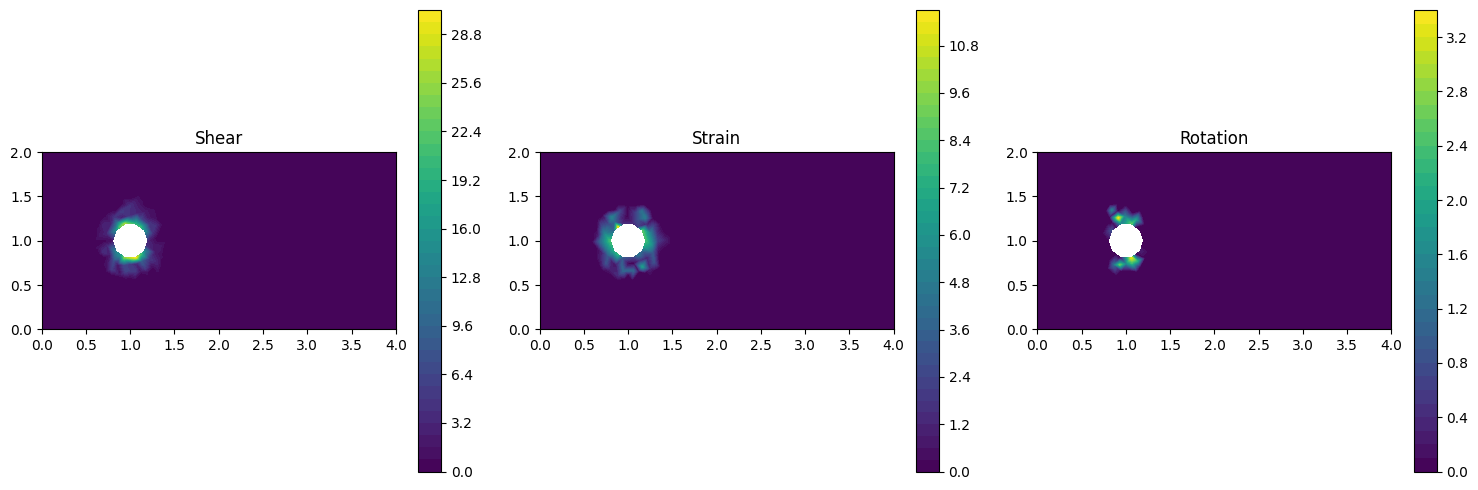

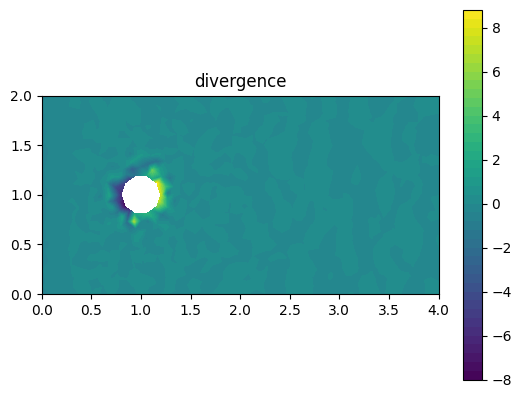

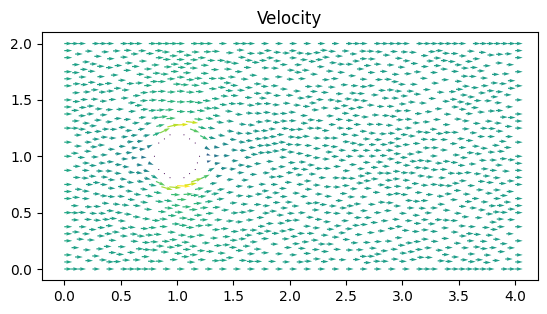

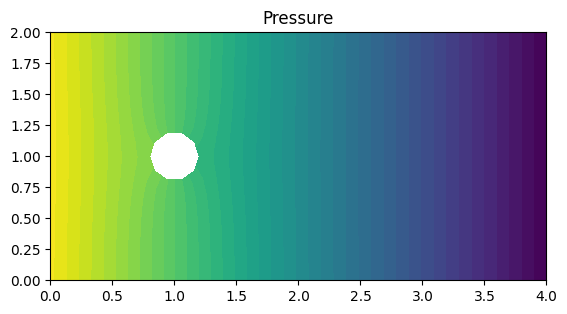

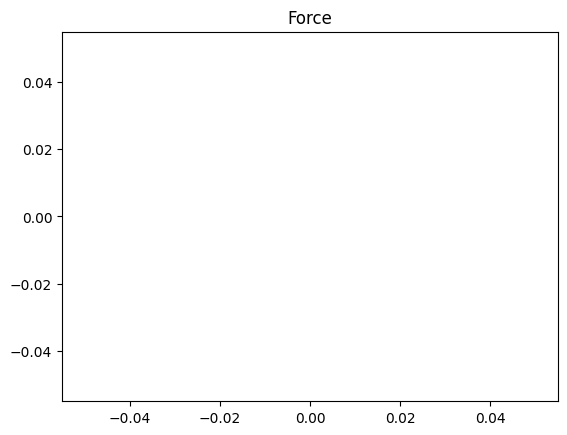

Time t = 3.022665674238231


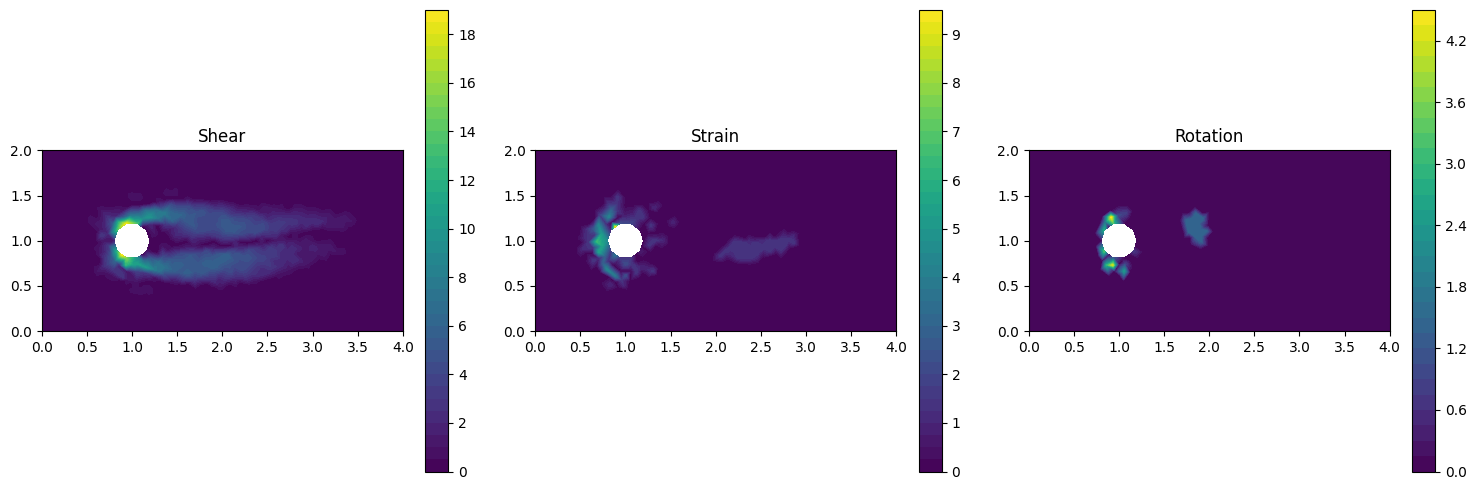

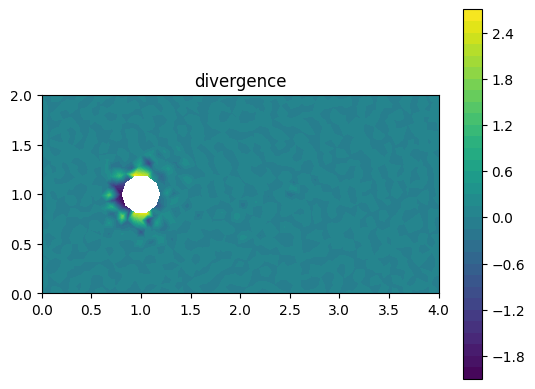

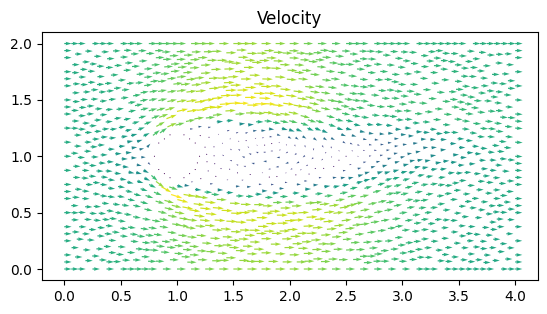

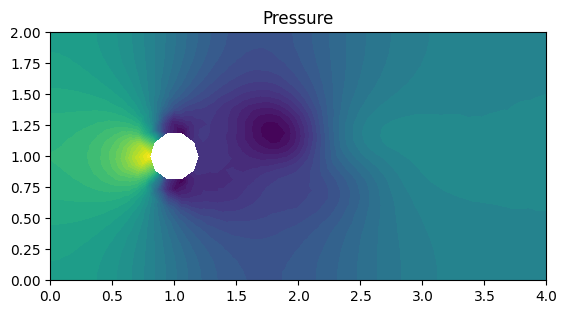

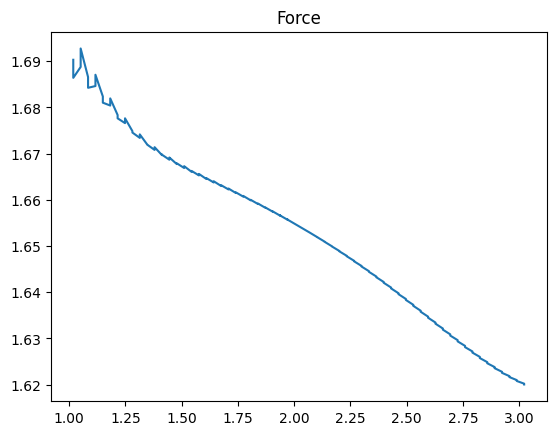

Time t = 6.012476286799972


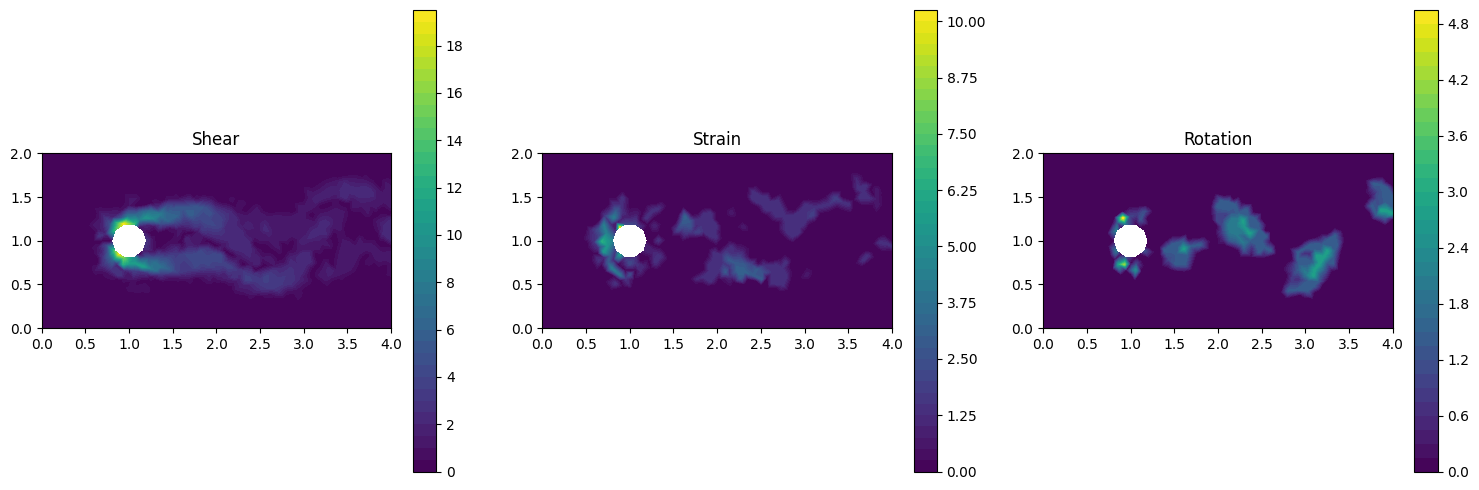

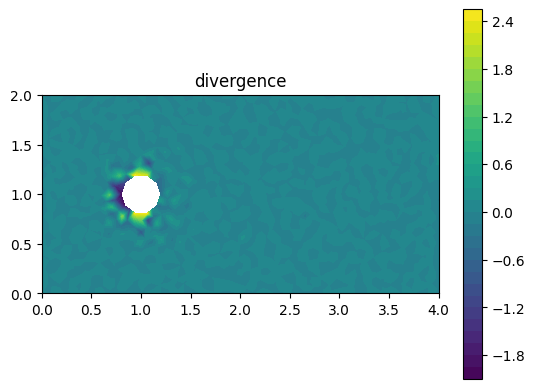

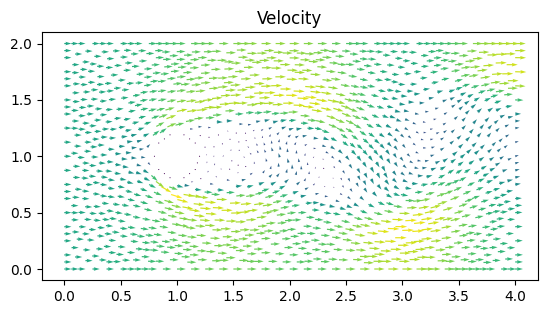

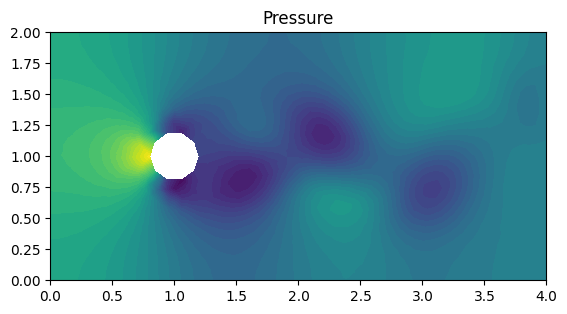

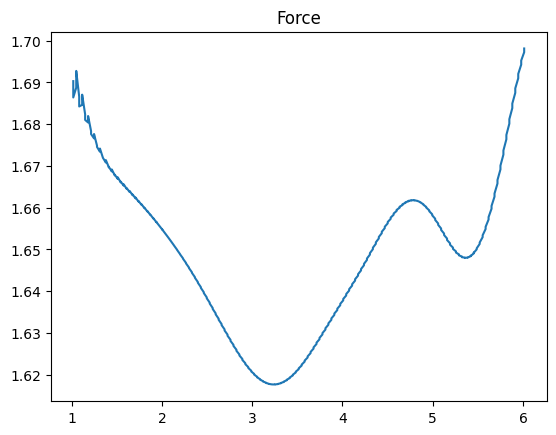

Time t = 9.002286899361685


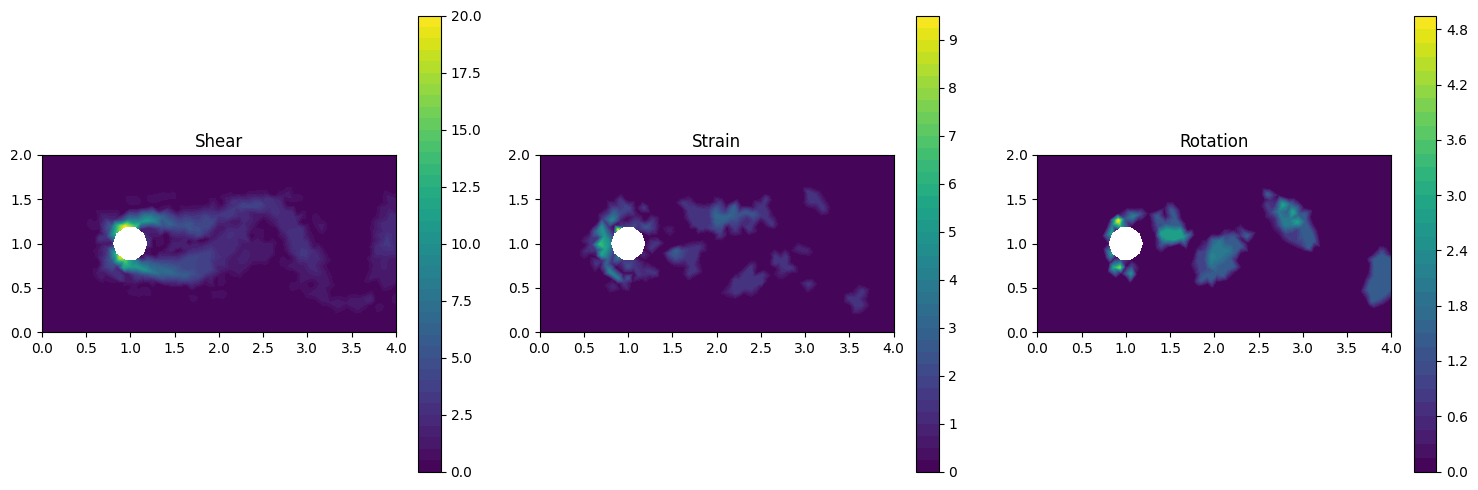

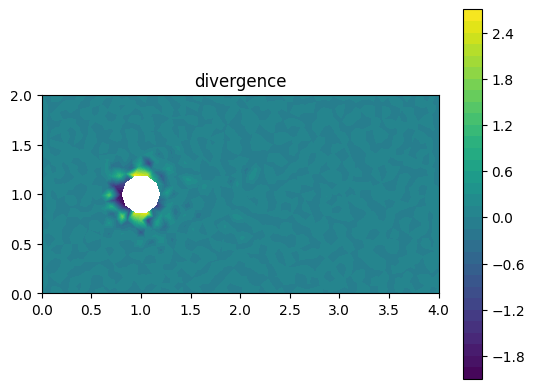

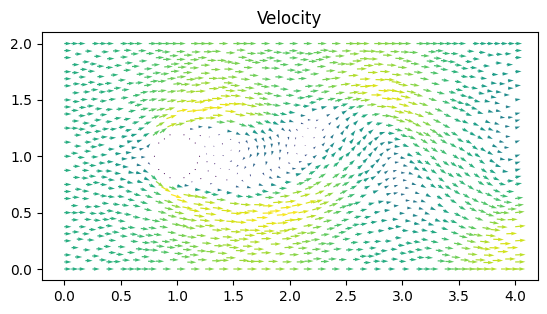

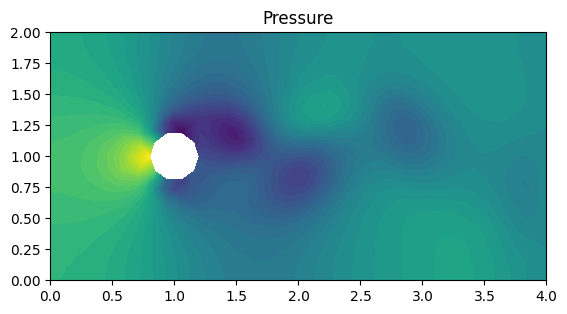

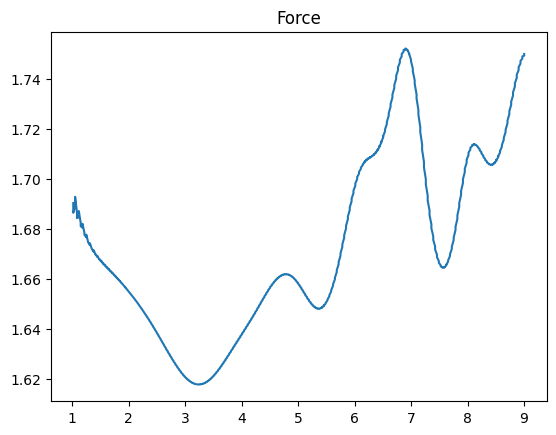

Time t = 12.024952573599847


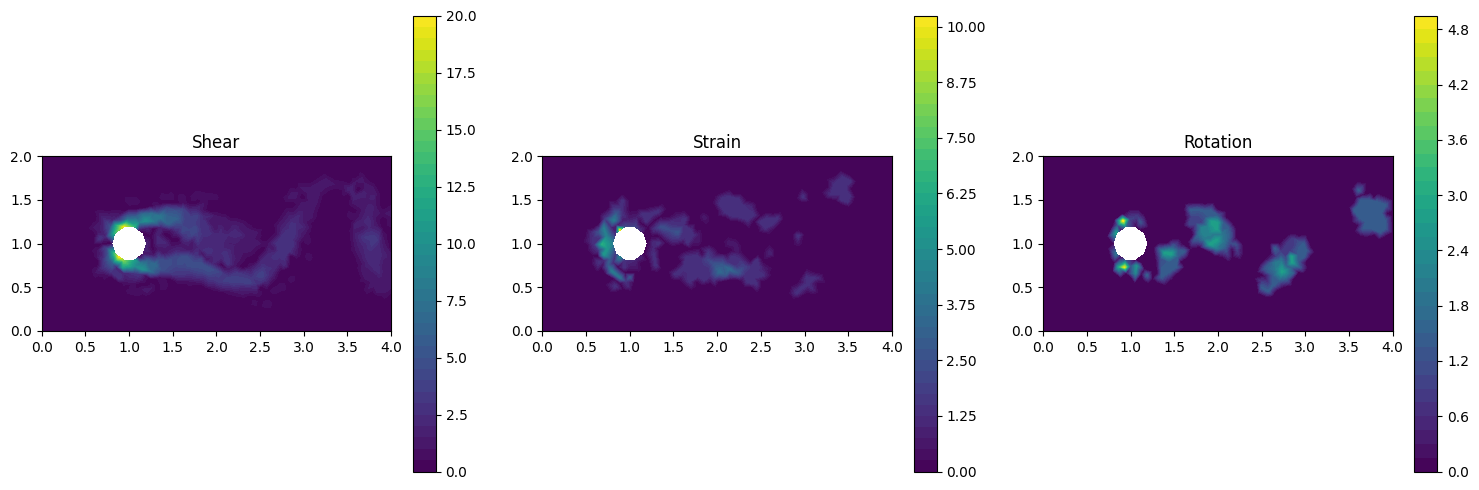

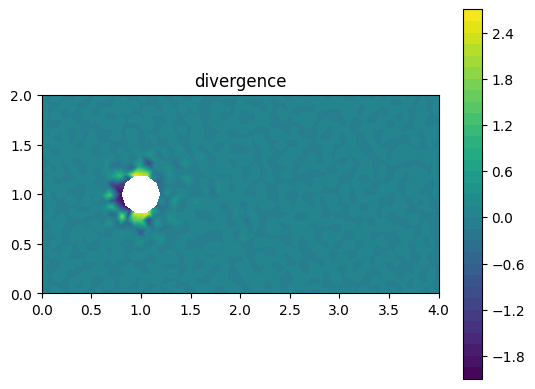

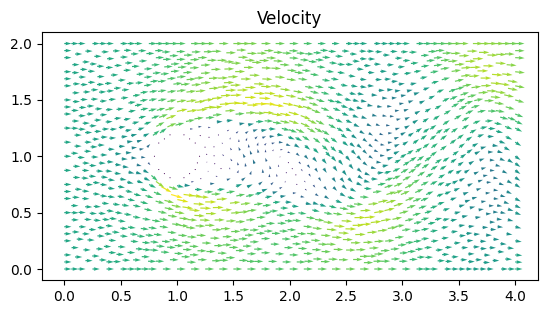

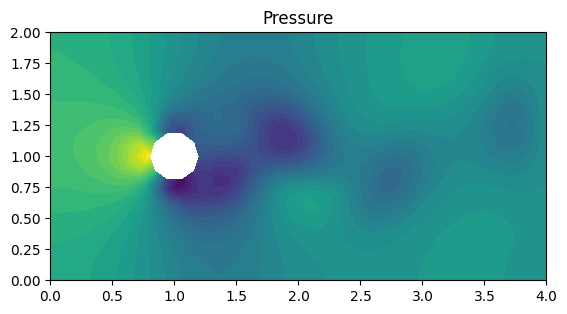

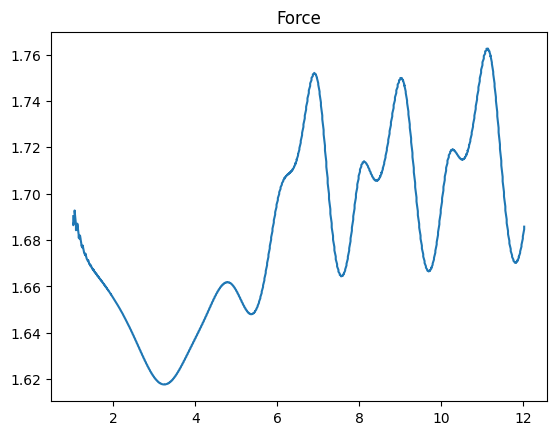

Time t = 15.014763186161508


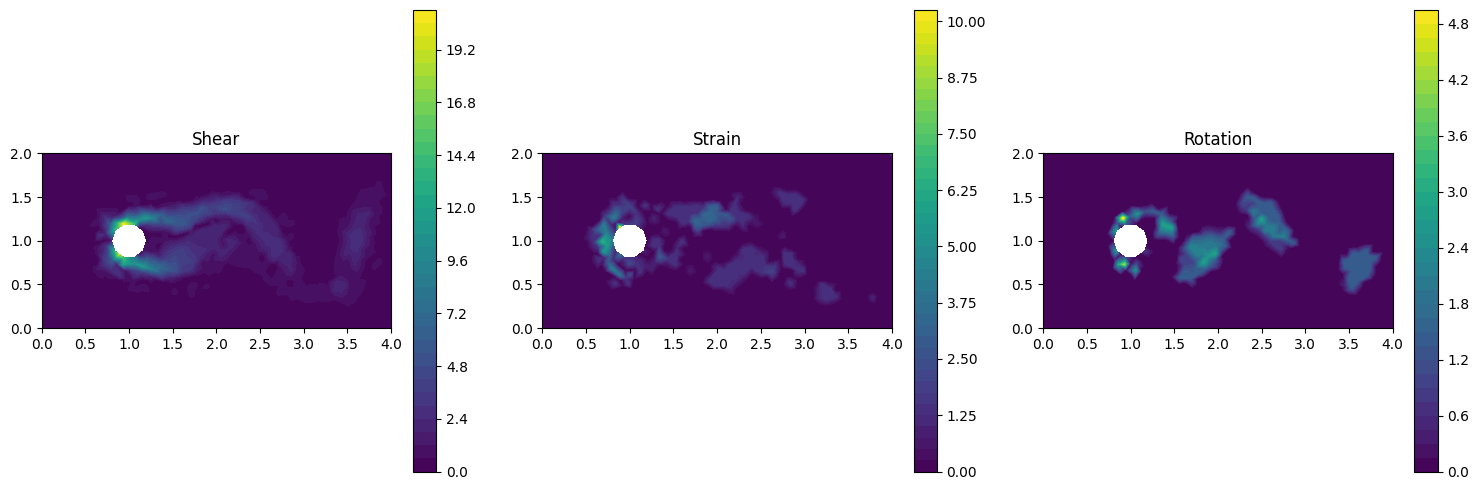

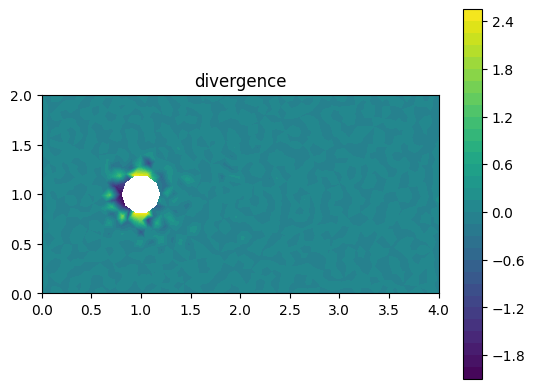

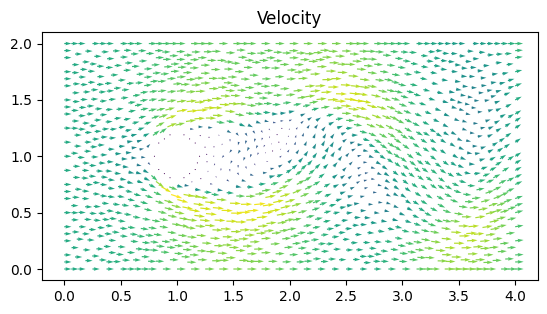

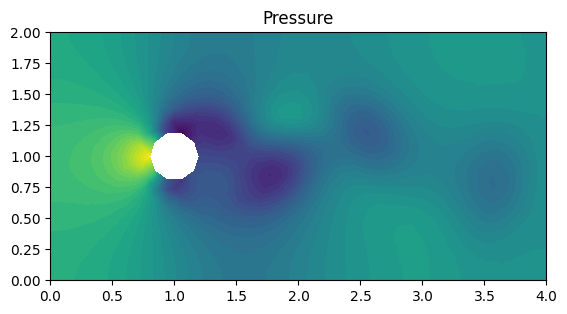

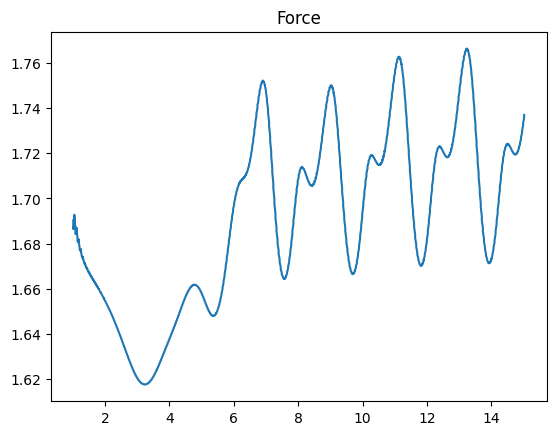

Time t = 18.00457379872328


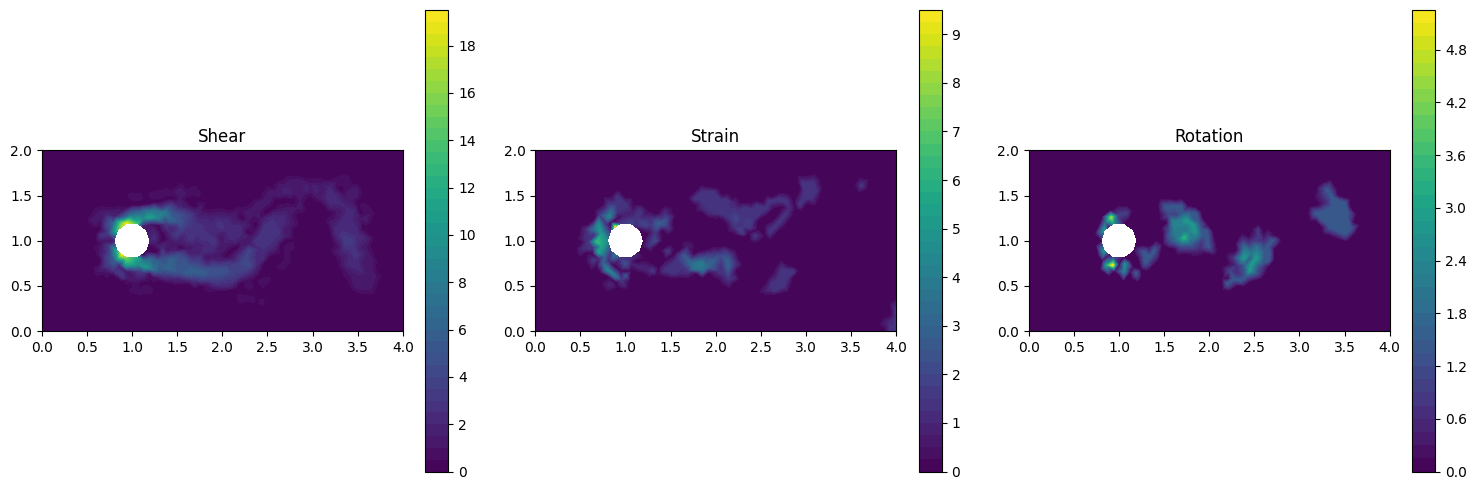

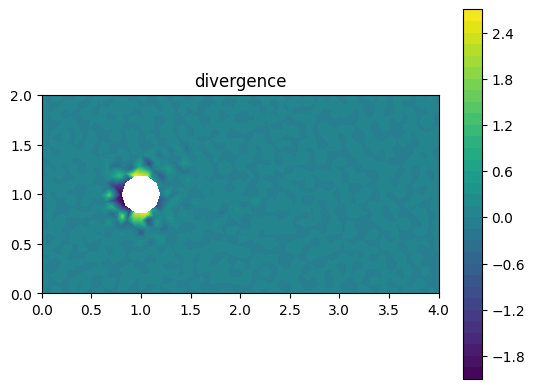

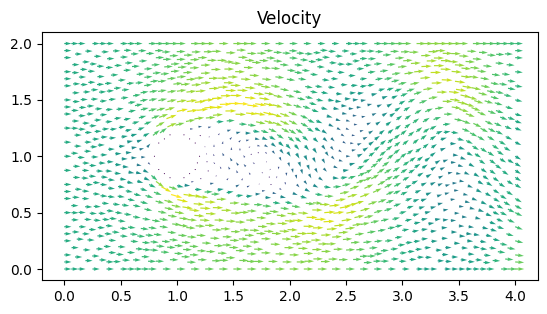

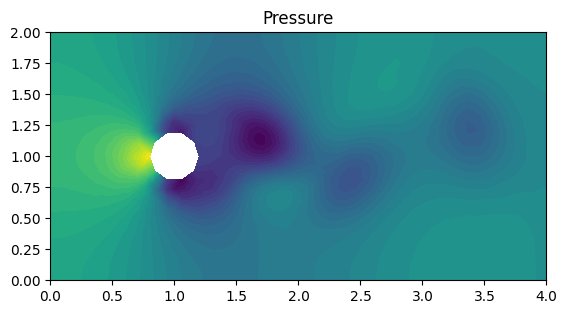

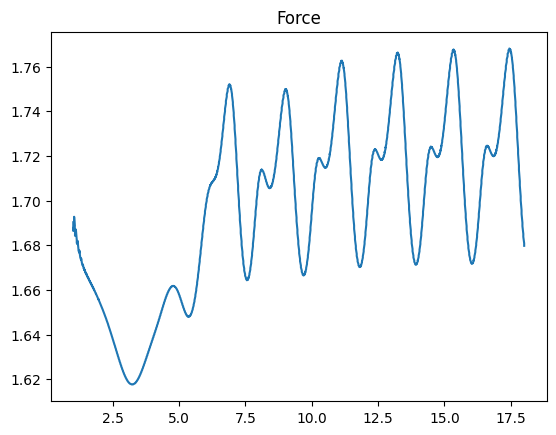

Time t = 21.027239472961604


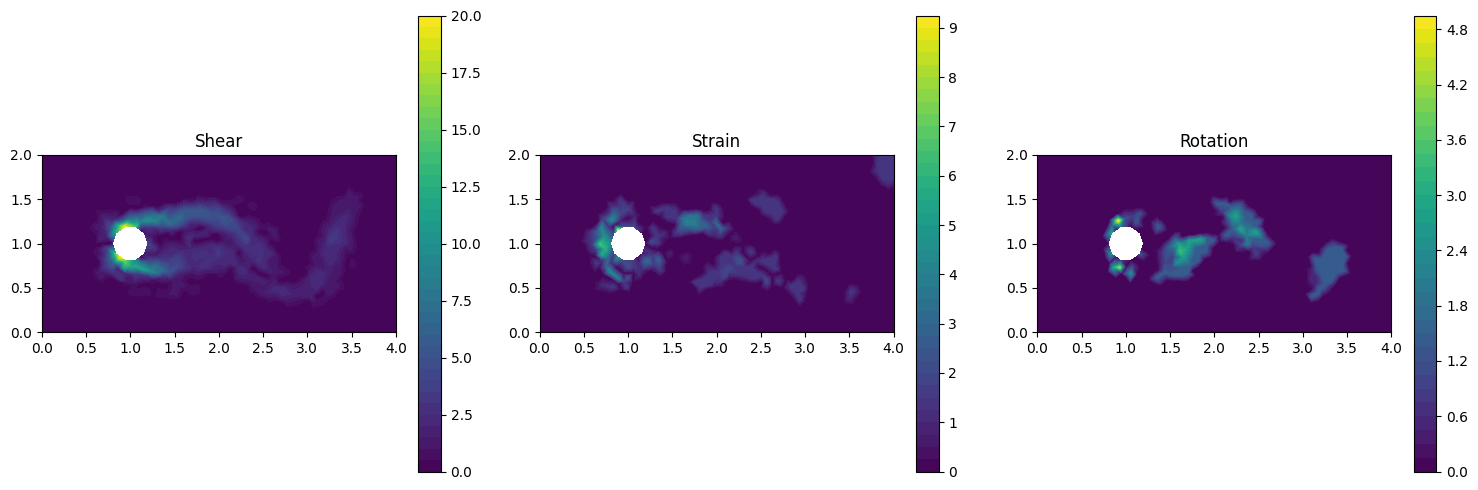

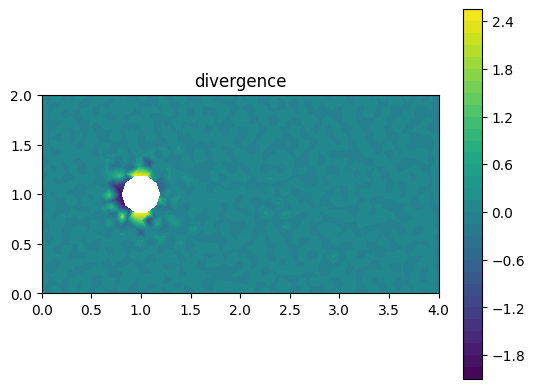

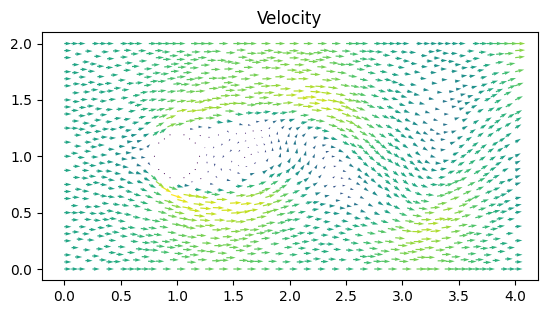

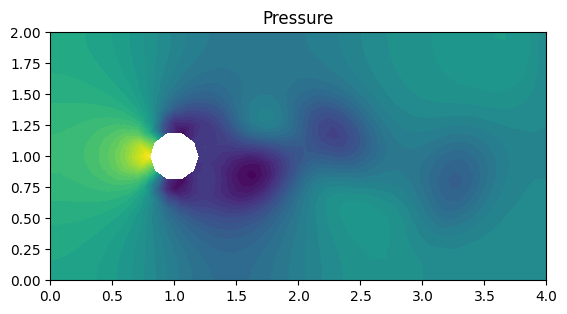

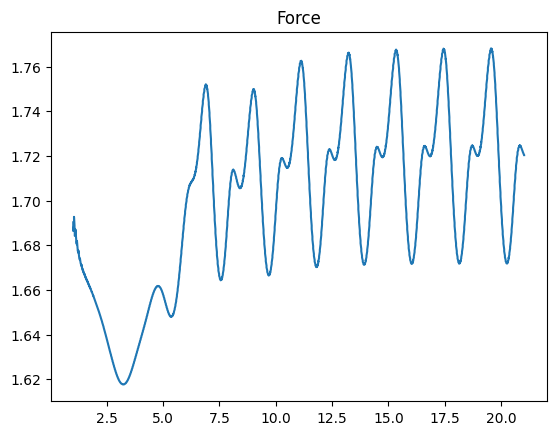

Time t = 24.017050085523426


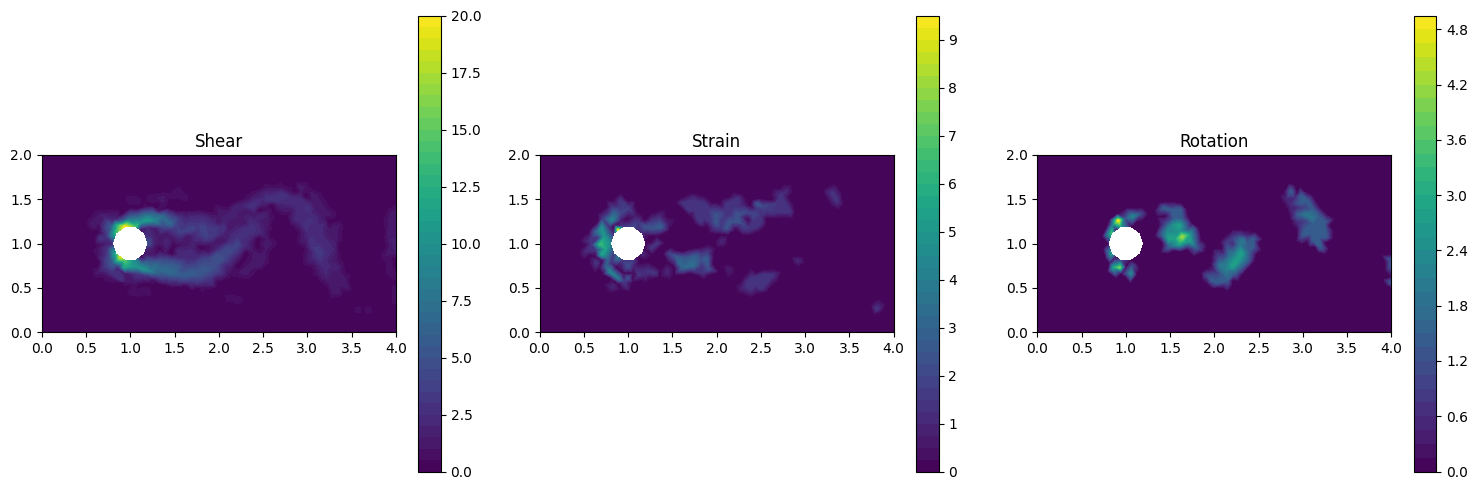

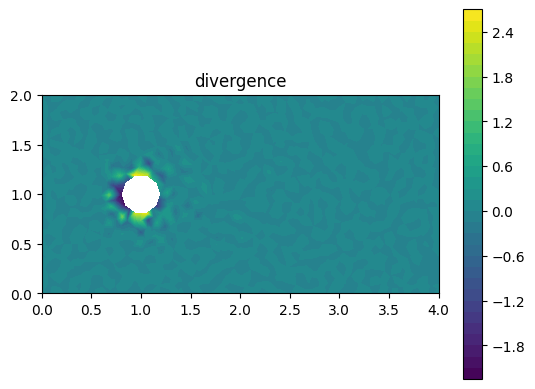

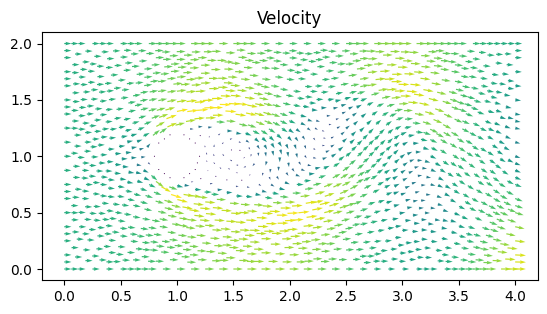

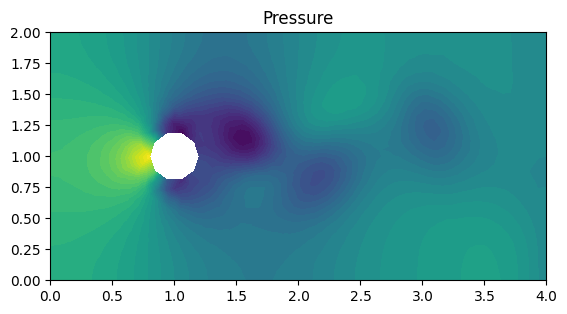

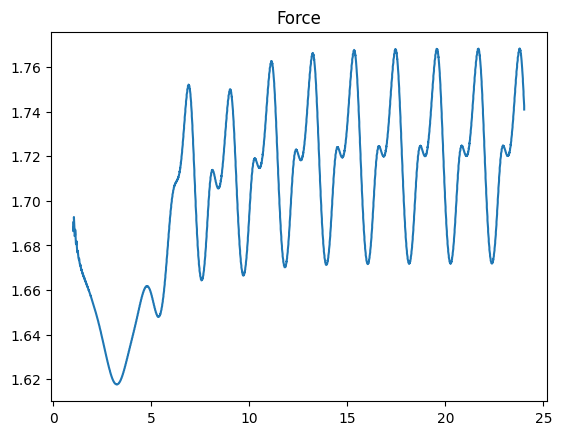

Time t = 27.006860698085248


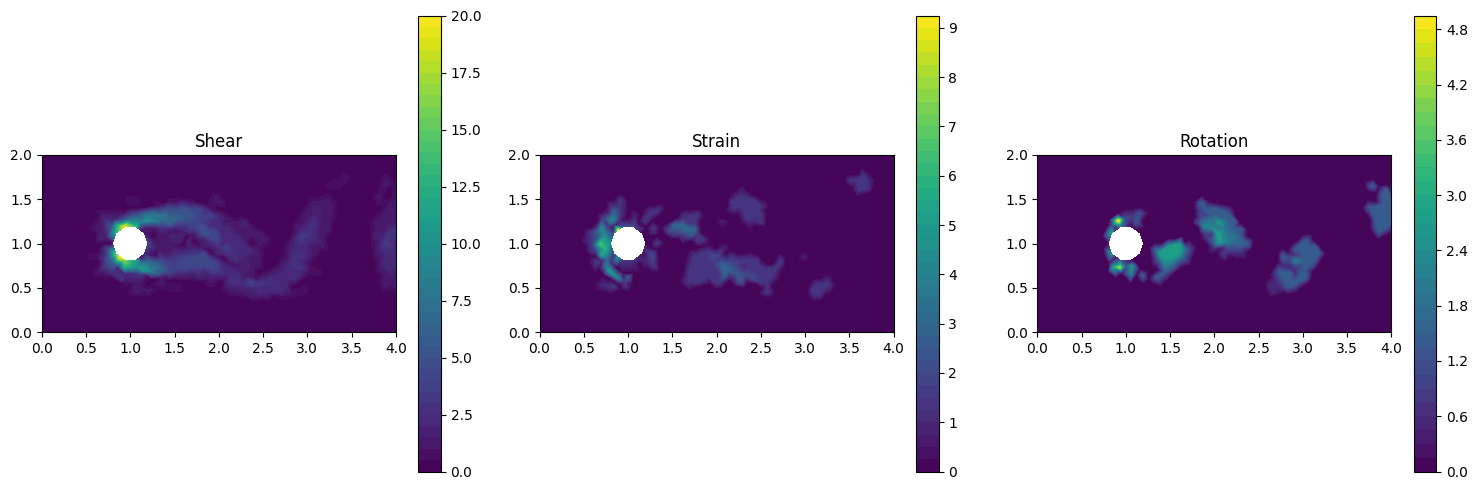

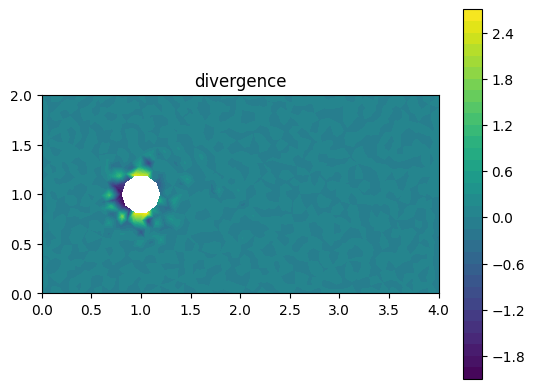

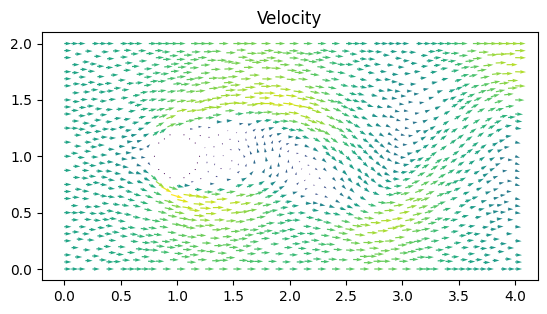

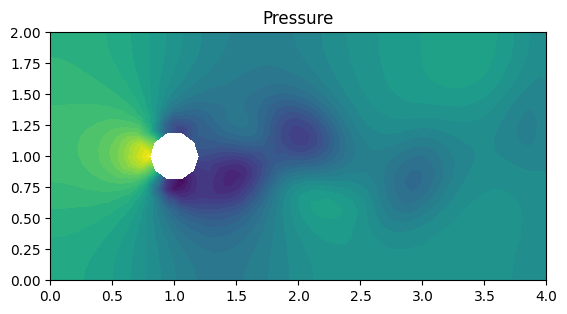

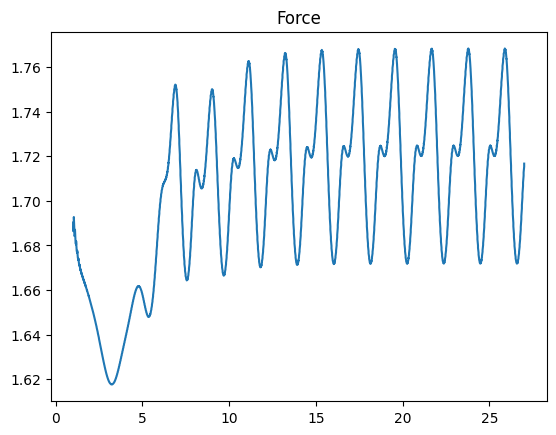

---------------
final timestep:
	Time t = 29.99667131064707
	RE = 100.0
	c_d = 1.7621047566044785
---------------



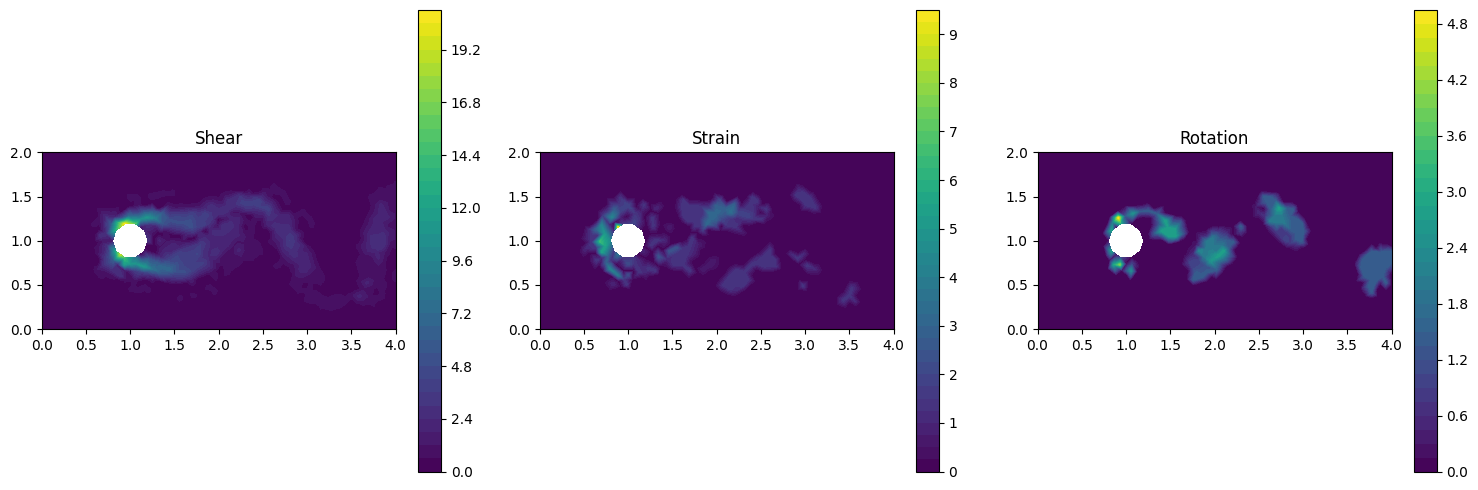

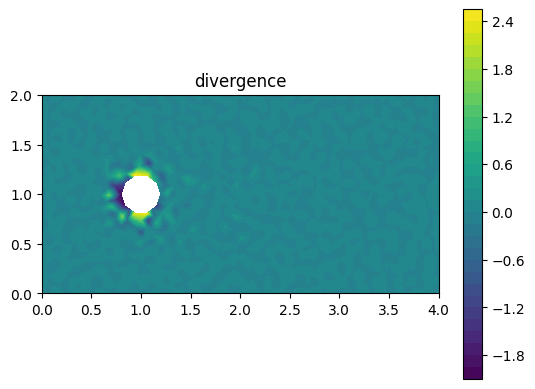

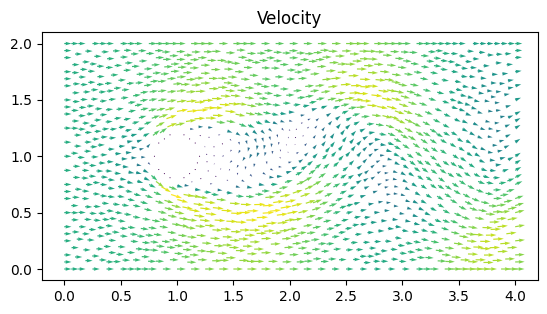

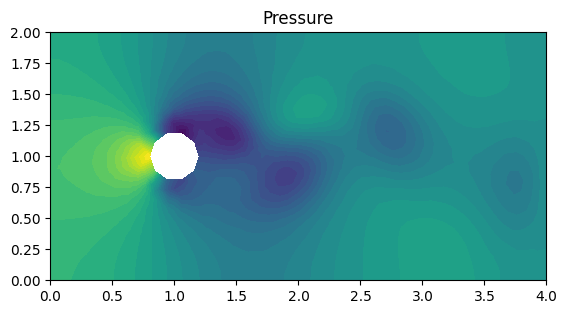

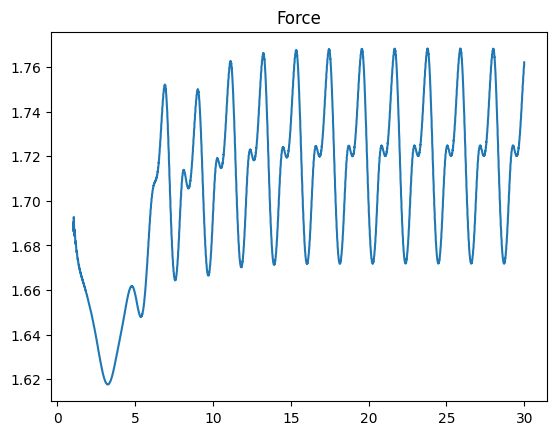

In [36]:
!rm results-NS/*

# Time stepping
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time or t + dt > T + DOLFIN_EPS:
        s = 'Time t = ' + repr(t)
        if t + dt > T + DOLFIN_EPS:
            print("---------------")
            print("final timestep:")
            print(f"\t{s}")
            print(f"\tRE = {RE}")
            print(f"\tc_{'l' if phi_x == 0 and phi_y == 1.0 else 'd'} = {F*normalization}")
            print("---------------\n")

        else:
            print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Triple decomposition
        V = TensorFunctionSpace(mesh, 'P', 1)
        grad_u1_prel = nabla_grad(u1)
        grad_u1 = project(grad_u1_prel, V)

        V2 = FunctionSpace(mesh, 'CG', 1)
        shear = Function(V2)
        elongation = Function(V2)
        rotation = Function(V2)
        dofmap = V2.dofmap()

        # Divergence
        divu = Function(V2)

        for vertex in vertices(mesh):
            point = vertex.point()
            grad_u1_point = grad_u1(point) # Evaluate the gradient tensor at the current point
            grad_u1_matrix = matrix = np.array([
                                                [grad_u1_point[0],grad_u1_point[1] ],
                                                [grad_u1_point[2], grad_u1_point[3]]
                                                                                       ])
            sh, el, rr = triple_decomposition(grad_u1_matrix)
            vertex_index = vertex.index()
            dof_index = vertex_to_dof_map(V2)[vertex_index]
            shear.vector()[dof_index] = sh
            elongation.vector()[dof_index] = el
            rotation.vector()[dof_index] = rr

            divu_vert = grad_u1_point[0] + grad_u1_point[3]
            divu.vector()[dof_index] = divu_vert

        # Plot Triple Decomposition
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        ax = plt.subplot(1, 3, 1)
        im = plot(shear, title = "Shear")
        plt.colorbar(im)
        ax = plt.subplot(1, 3, 2)
        im = plot(elongation, title = "Strain")
        plt.colorbar(im)
        ax = plt.subplot(1, 3, 3)
        im = plot(rotation, title = "Rotation")
        plt.colorbar(im)
        plt.tight_layout()
        plt.show()

        # Plot divergence
        plt.figure()
        im = plot(divu, title="divergence")
        plt.colorbar(im)

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Discussion**

## 1. Stability of the flow field for different Reynolds Numbers

We say a flow field is stable, when the components of the flow field (e.g. velocity and pressure) only change in space, but not in time.

### RE = 1:

The flow is stable.
First we have a look at the velocity field after 3s, 6s and 30s respectively.

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1_velocity_t3.png" width="300"/>](images/lab2/re1_velocity_t3.png)  [<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1_velocity_t6.png" width="300"/>](images/lab2/re1_velocity_t6.png)[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1_velocity_t30.png" width="300"/>](images/lab2/re1_velocity_t30.png)

After a short period the velocity field converges into a stable represontation. We can't differentiate the velocity fields between 3s and 30.
The same is true for the pressure (6s vs 30s):


[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1_pressure_t6.png" width="450"/>](images/lab2/re1_pressure_t6.png)  [<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1_pressure_t30.png" width="450"/>](images/lab2/re1_pressure_t30.png)

and the triple decomposition (also 6s vs 30s):

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1_triple_decomposition_t6.png" width="900"/>](images/lab2/re1_triple_decomposition_t6.png)[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1_triple_decomposition_t30.png" width="900"/>](images/lab2/re1_triple_decomposition_t30.png)

The lift force converges to a stable value after around 3s:

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1_force.png" width="900"/>](images/lab2/re1_force.png)


### RE = 10:

We see similar behavior as for RE = 1. The flow field is also stable.
The convergence for the flow field takes a litte bit longer.
We see the lift force coefficient converges after approx. 5s.

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re10_force.png" width="900"/>](images/lab2/re10_force.png)


### RE = 100:
Now things get more interesting. When we look at the lift force coefficient, we see the following behaviour:

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re100_force.png" width="900"/>](images/lab2/re100_force.png)

The lift force is not converging to a single value, which means the flow filed is constantly changing over time. Therefor the flow field is unstable.

We see the Karman vortex street, best visible in the shear and rotational part of the triple decomposition (depicted after 3s, 6s, 9s):

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re100_triple_decomposition_t3.png" width="900"/>](images/lab2/re100_triple_decomposition_t3.png)
[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re100_triple_decomposition_t6.png" width="900"/>](images/lab2/re100_triple_decomposition_t6.png)
[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re100_triple_decomposition_t9.png" width="900"/>](images/lab2/re100_triple_decomposition_t9.png)

### RE = 1000:

The force is now oscillating even more intensly (higher amplitude):

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1000_force.png" width="900"/>](images/lab2/re1000_force.png)

The flow is still unstable as expected. Here a comparison between 27s and 30s after start of the simulation:

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1000_triple_decomposition_t27.png" width="900"/>](images/lab2/re1000_triple_decomposition_t27.png)
[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1000_triple_decomposition_t30.png" width="900"/>](images/lab2/re1000_triple_decomposition_t30.png)

## 2. Drag and lift coefficients

Given the drag force $F_d$ and lift force $F_l$, the drag and lift coefficients are defined as

$$c_d = \frac{2F_d}{\rho U^2L}$$
and
$$c_l = \frac{2F_l}{\rho U^2L}.$$

For $\rho = 1$, $U = 1$, $L = 2 * rc = 0.4$ we get

$$ c_{d|l} = \frac{2F_{d|l}}{0.4}.$$
Thankfully this is already computed.

For a Reynoldsnumber RE = 1 and Re = 10 we get:

| RE   | $c_l$  | $c_d$  |
|------|--------|--------|
| 1    | 0.038  | 17.716 |
| 10   | 0.053  |  3.606 |
| 100  | d.n.c.$\dagger$ | d.n.c. |
| 1000 | d.n.c. | d.n.c. |

### Strouhal number

The Strouhal number is computed as
$$Sr = \frac{fL}{U}.$$
For given $L = 0.4$ and $U = 1$, we compute $Sr = 0.4f$.
For Reynoldsnumbers 1 and 10, no vortices are ejected after the cylinder, therefor no frequecy $f$.

To cumpute the frequency $f$ we have a look at the lift force using $c_l$.
For a $RE = 100$ we see:

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re100_force.png" width="900"/>](images/lab2/re100_force.png)

between t = 10s and t=30s we have approximatly 9.5 cycles, therefor the frequency $f = \frac{9.5}{20s} \approx 0.475 hz$.

It follows: $Sr = 0.4 * 0.475 = 0.19$.

For $RE = 1000$ we get similar results:

[<img src="https://raw.githubusercontent.com/paulmyr/DD2365-AdvancedCFD/refs/heads/master/images/lab2/re1000_force.png" width="900"/>](images/lab2/re1000_force.png)

Here we count approx. 10.5 cycles between t=10 and t=30.

It follows: $Sr = 0.4 * \frac{10.5}{20s} = 0.21$.

---
$\dagger$ d.n.c.: did not converge